# Saliency map

In this task you have a trained classifier and you want to see what parts of the image are the most important ones for the classifier to predict selected class. One of the simplest method to do this is to occlude some parts of the image and see how big is the drop in the class probability compared to the probability for the original image.

We want you to create a heatmap of those occlusions (2D np.array called `heatmap`). Take the original image and replace squares of size 20x20 centered at point (i,j) with a value of your choice. Then pass the image trough the network and calculate the drop in probability class. Do this on a grid with stride 10 ((0,0), (0,10), ..., (10,0), (10,10), ..., (220,220)), so your heatmap is a matrix with 23 rows and 23 columns.

You have to write a code to calculate this heatmap, that runs under 2 minutes.

###### Definitions

In [1]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from PIL import Image
import requests
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt


def get_image():
    url = "http://www.mimuw.edu.pl/~cygan/welonka.jpg"
    im = Image.open(requests.get(url, stream=True).raw)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    size = 224
    transformations = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            normalize,
        ])
    img_tensor = transformations(im.convert("RGB")).unsqueeze(0)
    return img_tensor

def get_model():
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    model.eval()
    return model

def plot_image(img_tensor, show = True):
    img_tensor_c = img_tensor.clone()
    img_tensor_c -= img_tensor_c.min()
    img_tensor_c /= img_tensor_c.max()
    plt.imshow(img_tensor_c[0].permute(1, 2, 0))
    if show:
        plt.show()

def plot_heatmap(heatmap):
    plt.matshow(heatmap)
    plt.colorbar()
    plt.show()

# Heatmap code

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_tensor_size_MB(tensor):
    num_elements = tensor.numel() # Total number of elements
    element_size = tensor.element_size() # Size of one element in bytes
    total_memory = num_elements * element_size # Total memory in bytes
    # print(f"Total memory: {total_memory / (2 ** 20):.2f} MB")

    return total_memory / (2 ** 20)

In [3]:
def calc_predictions(image_tensor, model, ram = 32, show = False):
    mem = get_tensor_size_MB(image_tensor)
    batches = int(mem / ram + 1)
    probabilities = []

    if show:
        plot_image(image_tensor)

    if batches > 1:
        idxs = np.linspace(0, len(image_tensor), batches, dtype = int)
        ranges = np.vstack([idxs[:-1], idxs[1:]]).T
    else:
        ranges = [[0, len(image_tensor)]]

    for left, right in ranges:
        batch = image_tensor[[np.arange(left, right)]]
        result = model(batch)

        batch_probs = torch.nn.functional.softmax(result, dim=-1)
        batch_probs = batch_probs.detach().numpy()
        probabilities += batch_probs[:, 1].tolist()

    return probabilities 


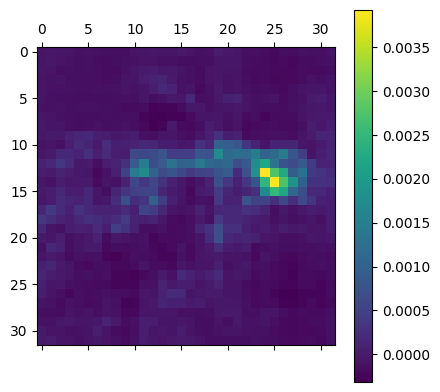

AssertionError: 

In [ ]:
SQUARE_SIZE = 10
STRIDE = 7

def generate_heatmap_vectorized(model, img_tensor):
    size = img_tensor.shape[-1]
    xx, yy = np.meshgrid(np.arange(0, size, STRIDE), np.arange(0, size, STRIDE))
    centers = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T

    first_prob = calc_predictions(img_tensor, model)[0]
    img_tensor = torch.tile(img_tensor, (len(centers),1,1,1)).detach()

    rows, cols = np.arange(size), np.arange(size)
    row_mask = (rows[None, :, None] >= centers[:, 0, None, None] - SQUARE_SIZE) 
    row_mask &= (rows[None, :, None] < centers[:, 0, None, None] + SQUARE_SIZE)

    col_mask = (cols[None, None, :] >= centers[:, 1, None, None] - SQUARE_SIZE)
    col_mask &= (cols[None, None, :] < centers[:, 1, None, None] + SQUARE_SIZE)

    full_mask = row_mask & col_mask
    full_mask = np.tile(full_mask[:, None, :, :], (1,3,1,1))

    img_tensor[full_mask] = 0

    with torch.no_grad():
      probabilities = np.array(calc_predictions(img_tensor, model))
    probabilities = probabilities.reshape((len(xx), len(yy)))
    probabilities = probabilities.swapaxes(0, 1)
    
    return first_prob - probabilities

heatmap = generate_heatmap_vectorized(get_model(), get_image())
plot_heatmap(heatmap)

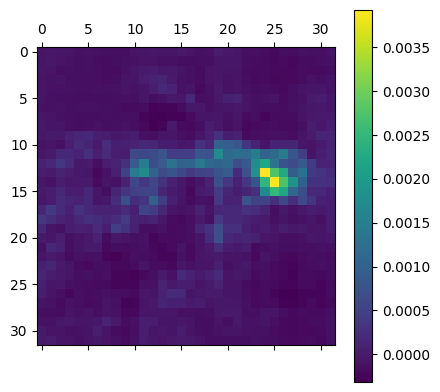

In [7]:
SQUARE_SIZE = 10
STRIDE = 7

def generate_heatmap(model, img_tensor):
    size = img_tensor.shape[-1]
    xx, yy = np.meshgrid(np.arange(0, size, STRIDE), np.arange(0, size, STRIDE))
    centers = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T

    first_prob = calc_predictions(img_tensor, model)[0]
    heatmap = np.zeros((len(xx) * len(yy)))

    for i, (x, y) in enumerate(centers):
        xs, xe = np.max([0, x - SQUARE_SIZE]), np.min([size, x + SQUARE_SIZE])
        ys, ye = np.max([0, y - SQUARE_SIZE]), np.min([size, y + SQUARE_SIZE])

        occluded = img_tensor.clone()

        occluded[:, :, ys:ye, xs:xe] = 0

        with torch.no_grad():
          pred = calc_predictions(occluded, model, show = False)
        heatmap[i] = pred[0]

    heatmap = first_prob - heatmap.reshape((len(xx), len(yy)))

    return heatmap 

heatmap = generate_heatmap(get_model(), get_image())
plot_heatmap(heatmap)


# Test

In [ ]:
img_tensor = get_image()
model = get_model()

heatmap = generate_heatmap(model, img_tensor)

plot_image(img_tensor)
plot_heatmap(heatmap)